In [38]:
import pandas as pd 
import numpy as np 
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
pd.set_option('display.max_columns', None)

In [18]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [19]:
df.drop(['date_install','first_command_time','birthday','sex','time_confirm_email'],axis=1,inplace=True)

In [20]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name']

In [21]:
def prepare_obj_data(df, obj_cols):
    '''
    Подготовка колонок с типом данных object
    
    Args:
        df: pd.DataFrame
        obj_cols: list of str 
    Returns:
        pd.DataFrame
    '''
    
    cheat_count_is_cheater = df['is_cheater'].value_counts().index[0]
    cheat_count_has_email = df['has_email'].value_counts().index[0]
    
    df['is_cheater'] = df['is_cheater'].fillna(cheat_count_is_cheater)
    df['has_email'] = df['has_email'].fillna(cheat_count_has_email)
    
    df['country'] = df['country'].fillna('other')
    df['network_name'] = df['network_name'].fillna('other')

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
    
    df.drop(obj_cols, axis=1, inplace=True)
        
    return df


In [22]:
df = prepare_obj_data(df, obj_cols)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [24]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y_stratified, random_state=42)


In [25]:
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

Будем решать задачу классификации для определения людей которые платят. После того как определили кто заплатил, решаем задачу регрессии

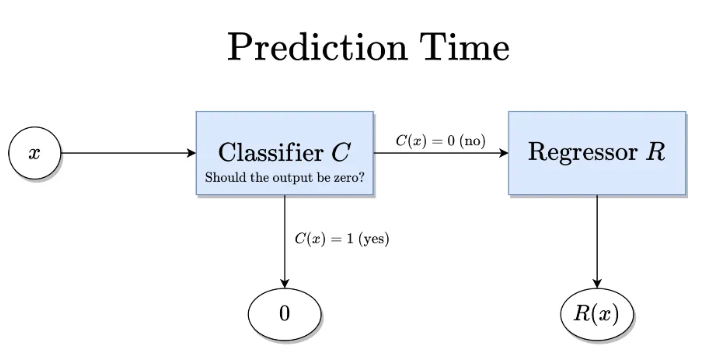

## Classification

In [26]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [27]:
def plot_importance_reg(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.coef_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [28]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)

In [29]:
def train_model(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train,verbose=50, plot=True))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

In [30]:
def train_model_reg(model_obj, X_train, y_train, num_folds ,scoring, cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train, verbose=50, plot=True))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.104069
0:	learn: 0.4945940	total: 45.8ms	remaining: 45.7s
50:	learn: 0.0691219	total: 2.38s	remaining: 44.3s
100:	learn: 0.0675392	total: 4s	remaining: 35.6s
150:	learn: 0.0664659	total: 6.79s	remaining: 38.2s
200:	learn: 0.0654600	total: 8.96s	remaining: 35.6s
250:	learn: 0.0646207	total: 11.5s	remaining: 34.3s
300:	learn: 0.0638508	total: 13.8s	remaining: 32.1s
350:	learn: 0.0630582	total: 15.3s	remaining: 28.3s
400:	learn: 0.0624395	total: 16.9s	remaining: 25.3s
450:	learn: 0.0617273	total: 18.7s	remaining: 22.8s
500:	learn: 0.0611505	total: 20.4s	remaining: 20.3s
550:	learn: 0.0605131	total: 22.1s	remaining: 18s
600:	learn: 0.0599181	total: 23.5s	remaining: 15.6s
650:	learn: 0.0592789	total: 25.4s	remaining: 13.6s
700:	learn: 0.0586238	total: 27.3s	remaining: 11.6s
750:	learn: 0.0579455	total: 29s	remaining: 9.6s
800:	learn: 0.0573923	total: 30.7s	remaining: 7.64s
850:	learn: 0.0569135	total: 32.4s	remaining: 5.66s
900:	learn: 0.0562935	total: 33.8s	remaining

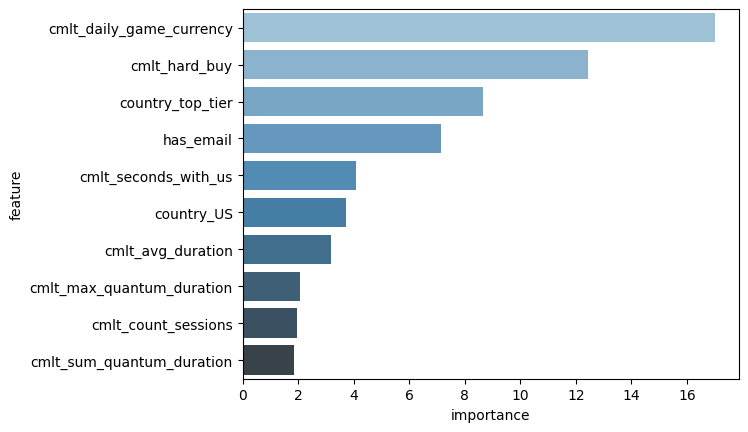

In [31]:
params = {
    'iterations': 200,
    'depth': 3,
    'loss_function': 'Logloss',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20,
    'thread_count': -1
}

model, features = train_model(CatBoostClassifier(),
                              X_train, 
                              y_train_binary,
                              5,
                              scoring='roc_auc',
                              cross_val=True)

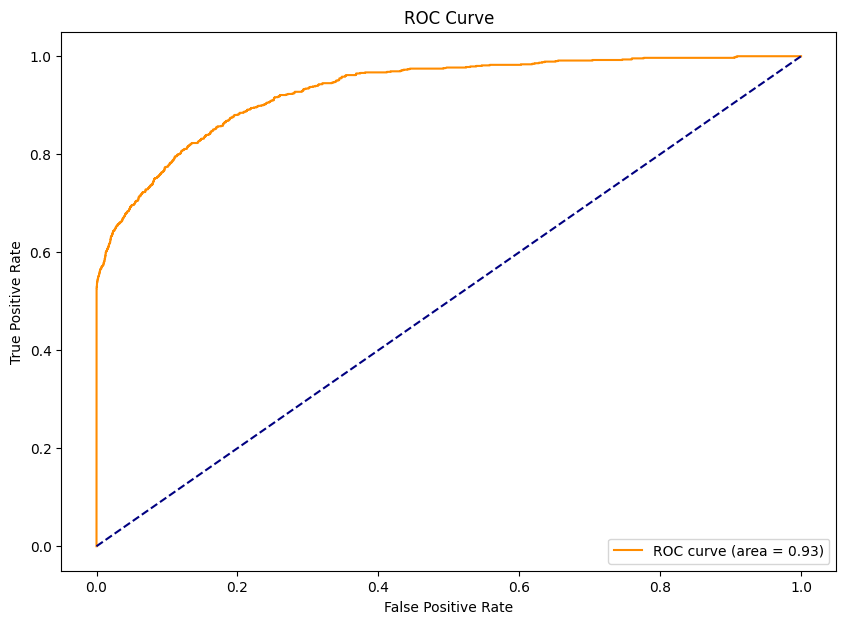

In [41]:
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


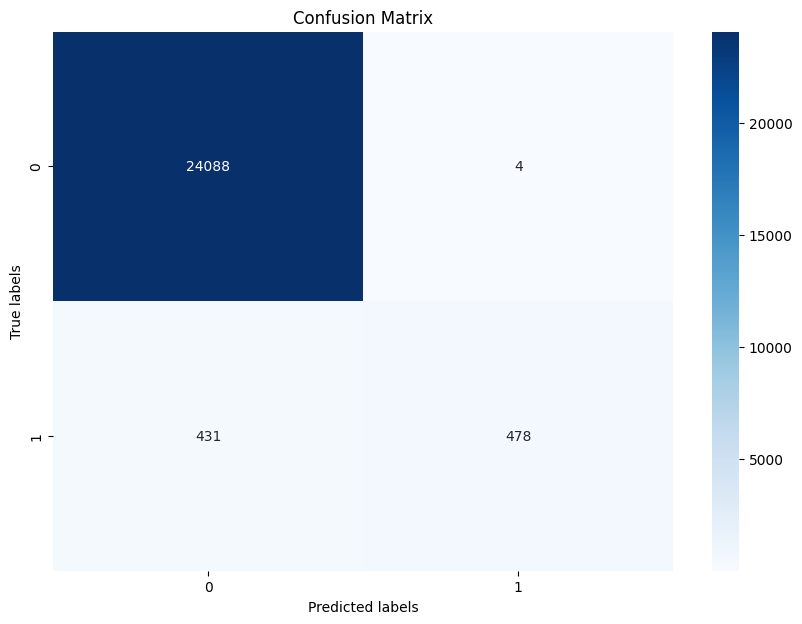

In [45]:
y_pred_confusion = model.predict(X_test)

conf_matrix = confusion_matrix(y_test_binary, y_pred_confusion)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [46]:
X_train_regression = X_train[y_train_binary == 1]
y_train_regression = y_train[y_train_binary == 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 12970.5508190	total: 5.67ms	remaining: 1.7s
50:	learn: 11766.9967003	total: 135ms	remaining: 658ms
100:	learn: 11530.6810978	total: 231ms	remaining: 456ms
150:	learn: 11444.2111588	total: 318ms	remaining: 314ms
200:	learn: 11358.5831671	total: 406ms	remaining: 200ms
250:	learn: 11313.2228220	total: 492ms	remaining: 96.1ms
299:	learn: 11269.6000384	total: 578ms	remaining: 0us
0:	learn: 13119.3065972	total: 1.91ms	remaining: 572ms
50:	learn: 11877.5006347	total: 79.2ms	remaining: 387ms
100:	learn: 11630.4974599	total: 160ms	remaining: 316ms
150:	learn: 11537.6837555	total: 237ms	remaining: 234ms
200:	learn: 11436.3268160	total: 316ms	remaining: 155ms
250:	learn: 11370.2565129	total: 395ms	remaining: 77.1ms
299:	learn: 11314.2594629	total: 471ms	remaining: 0us
0:	learn: 13050.0896507	total: 1.68ms	remaining: 502ms
50:	learn: 11849.4174841	total: 79.6ms	remaining: 389ms
100:	learn: 11602.4505492	total: 193ms	remaining: 380ms
150:	learn: 11505.9149258	total: 292ms	remaining: 288ms

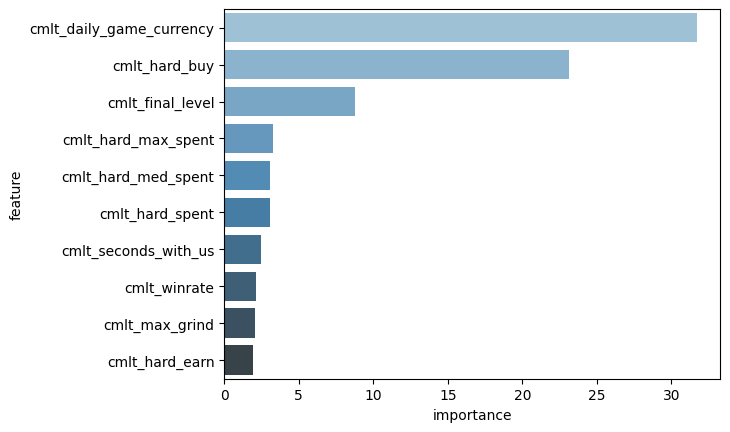

In [103]:
params = {
    'iterations': 300,
    'depth': 4,
    'loss_function': 'MAE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20 
}

model_reg, features_reg = train_model_reg(CatBoostRegressor(**params),
                              X_train_regression, 
                              y_train_regression,
                              5,
                              scoring='neg_mean_absolute_error',
                              cross_val=True)

In [104]:
y_pred_train_binary = model.predict(X_train)
y_pred_test_binary = model.predict(X_test)

In [105]:
y_pred_train_regression = model_reg.predict(X_train_regression)
y_pred_test_regression = model_reg.predict(X_test[y_test_binary == 1])

In [106]:
smape_train_regression = SMAPE(y_train_regression, y_pred_train_regression)
smape_test_regression = SMAPE(y_test[y_test_binary == 1], y_pred_test_regression) 

mse_train = mean_squared_error(y_train_regression, y_pred_train_regression)
mse_test = mean_squared_error(y_test[y_test_binary == 1], y_pred_test_regression)

rmse_train = sqrt(mse_train)
rmse_test = sqrt(mse_test)

mae_train = mean_absolute_error(y_train_regression, y_pred_train_regression)
mae_test = mean_absolute_error(y_test[y_test_binary == 1], y_pred_test_regression)

In [107]:
print(f"SMAPE for train data (regression): {smape_train_regression}")
print(f"SMAPE for test data (regression): {smape_test_regression}")

print(f"RMSE for train data: {rmse_train}")
print(f"RMSE for test data: {rmse_test}")

print('Train MAE: ',  mean_absolute_error(y_train_regression, y_pred_train_regression))
print('Test MAE: ',  mean_absolute_error(y_test[y_test_binary == 1], y_pred_test_regression))


SMAPE for train data (regression): 1.0086320430251678
SMAPE for test data (regression): 1.0314098306457178
RMSE for train data: 41982.545016912634
RMSE for test data: 36880.85157932285
Train MAE:  11269.600048685621
Test MAE:  10165.939136443816
